# Import Libraries

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re


import keras
keras.__version__
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.filterwarnings('ignore')
import re
import string


#https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets

In [2]:
'''
following format:
<ID><tab><Target><tab><Tweet><tab><Stance><tab><Opinion towards><tab><Sentiment>

where
<ID> is an internal identification number;
<Target> is the entity of interest (e.g., "Hillary Clinton");
<Tweet> is the text of a tweet;
<Stance> is the stance label;
<Opinion towards> is the label for the target of opinion;
<Sentiment> is the sentiment label.
'''

'\nfollowing format:\n<ID><tab><Target><tab><Tweet><tab><Stance><tab><Opinion towards><tab><Sentiment>\n\nwhere\n<ID> is an internal identification number;\n<Target> is the entity of interest (e.g., "Hillary Clinton");\n<Tweet> is the text of a tweet;\n<Stance> is the stance label;\n<Opinion towards> is the label for the target of opinion;\n<Sentiment> is the sentiment label.\n'

In [5]:
train_data = pd.read_csv("labeled_stance_train.txt", sep="\t", header=0)
test_data = pd.read_csv("labeled_stance_test.txt", sep="\t", header=0)

train_data.head(10)

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST
5,106,Atheism,If we are unsure whether something is halal or...,AGAINST
6,107,Atheism,"Papa God, i pray that You shower me with more ...",AGAINST
7,108,Atheism,Now that the SCOC has ruled Canadians have fre...,FAVOR
8,109,Atheism,"Wow, unsubstantiated claims about spooks. Reme...",NONE
9,110,Atheism,"RT ""...That kind of modesty is too arrogant fo...",NONE


In [6]:
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (2814, 4)
Test Data Shape:  (1249, 6)


In [7]:
test_data.head()

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,10001,Atheism,He who exalts himself shall be humbled; a...,AGAINST,TARGET,POSITIVE
1,10002,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,AGAINST,TARGET,NEITHER
2,10003,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,AGAINST,TARGET,POSITIVE
3,10004,Atheism,#God is utterly powerless without Human interv...,AGAINST,TARGET,NEGATIVE
4,10005,Atheism,@David_Cameron Miracles of #Multiculturalism...,AGAINST,OTHER,NEGATIVE


In [8]:
test_data['Opinion towards'].value_counts()

TARGET    824
OTHER     382
NO ONE     43
Name: Opinion towards, dtype: int64

In [9]:
#Drop all rows where Opinion Towards != TARTGET

test_data.drop(test_data.loc[test_data['Opinion towards'] != "TARGET"].index, axis=0, inplace=True)

In [11]:
test_data['Opinion towards'].value_counts()

TARGET    824
Name: Opinion towards, dtype: int64

In [12]:
test_data.drop(columns=['Opinion towards', 'Sentiment'], axis=1, inplace=True)

In [13]:
data = pd.concat([train_data, test_data])

In [14]:
data['Target'].value_counts()

Feminist Movement                   856
Hillary Clinton                     821
Legalization of Abortion            782
Atheism                             656
Climate Change is a Real Concern    523
Name: Target, dtype: int64

# Create a new Feminist dataframe for multiclass classification

In [17]:
data_feminist = pd.DataFrame(data.loc[data['Target'] == 'Feminist Movement'].values)

In [18]:
data_feminist

,0,1,2,3
0,1009,Feminist Movement,Always a delight to see chest-drumming alpha m...,FAVOR
1,1010,Feminist Movement,Sometimes I overheat and want to take off my s...,FAVOR
2,1011,Feminist Movement,If feminists spent 1/2 as much time reading pa...,AGAINST
3,1012,Feminist Movement,"Stupid Feminists, the civilization you take fo...",AGAINST
4,1013,Feminist Movement,YOU'RE A GIRL AND HAVE A SEX DRIVE!? YOU MUST ...,FAVOR
...,...,...,...,...
851,10669,Feminist Movement,"The more you push me, the more I resist. Don't...",FAVOR
852,10670,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...,FAVOR
853,10671,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad...",FAVOR
854,10672,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....,AGAINST


In [20]:
data_feminist[3] = data_feminist[3].map({'AGAINST': -1, 'NONE': 0, 'FAVOR': 1})

In [25]:
data_feminist.drop(columns=[0], axis=1, inplace=True)

In [26]:
data_feminist

,2,3
0,Always a delight to see chest-drumming alpha m...,1
1,Sometimes I overheat and want to take off my s...,1
2,If feminists spent 1/2 as much time reading pa...,-1
3,"Stupid Feminists, the civilization you take fo...",-1
4,YOU'RE A GIRL AND HAVE A SEX DRIVE!? YOU MUST ...,1
...,...,...
851,"The more you push me, the more I resist. Don't...",1
852,@Maisie_Williams is our hero with her #LikeAGi...,1
853,"Rather be an ""ugly"" feminist then be these sad...",1
854,iamNovaah: RT ChrzOC: Bitches be running wild....,-1


In [27]:
#importing stopword from nltk
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

#apply process_tweets function to each entry in the text feature
data_feminist['processed_tweets'] = data_feminist[2].apply(lambda x: process_tweets(x))

In [31]:
data_feminist

,2,3,processed_tweets
0,Always a delight to see chest-drumming alpha m...,1,lways delight see chestdrumming alpha male his...
1,Sometimes I overheat and want to take off my s...,1,ometimes overheat want take shirt cant social ...
2,If feminists spent 1/2 as much time reading pa...,-1,feminist spent 12 much time reading paper tumb...
3,"Stupid Feminists, the civilization you take fo...",-1,tupid feminist civilization take granted built...
4,YOU'RE A GIRL AND HAVE A SEX DRIVE!? YOU MUST ...,1,oure girl sex drive must slut feminist semst
...,...,...,...
851,"The more you push me, the more I resist. Don't...",1,push resist dont bother strongwomen woman semst
852,@Maisie_Williams is our hero with her #LikeAGi...,1,maisiewilliams hero likeagirl campaign brillia...
853,"Rather be an ""ugly"" feminist then be these sad...",1,ather ugly feminist sad people throw hat peopl...
854,iamNovaah: RT ChrzOC: Bitches be running wild....,-1,amnovaah rt chrzoc bitch running wild feminazi...


# TFIDF Vectorizing and Spltting dataset

In [37]:
X = pd.DataFrame(data_feminist['processed_tweets'].values)
y = data_feminist[3].values

X

,0
0,lways delight see chestdrumming alpha male his...
1,ometimes overheat want take shirt cant social ...
2,feminist spent 12 much time reading paper tumb...
3,tupid feminist civilization take granted built...
4,oure girl sex drive must slut feminist semst
...,...
851,push resist dont bother strongwomen woman semst
852,maisiewilliams hero likeagirl campaign brillia...
853,ather ugly feminist sad people throw hat peopl...
854,amnovaah rt chrzoc bitch running wild feminazi...


In [43]:
X[0]

<1x3304 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [48]:
#Split dataset of 200,000 processed tweets into 80% for training data
#and remaining 20% on testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=1)

In [49]:
#display shapes of training and testing 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (770, 3304)
y_train (770,)

X_test (86, 3304)
y_test (86,)


# Machine Learning Models For Multiclass Classification of Tweet Stance

In [50]:
'''
define a function that can be used for any machine learning algorithm
outputs
accuracy score on training and testing data
evaluation metrics
confusion matrix
'''

def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

## Random Forest Classifier and hypterparameter tuning

In [47]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

Accuracy of model on training data : 86.8421052631579
Accuracy of model on testing data : 56.395348837209305 

              precision    recall  f1-score   support

          -1       0.57      0.96      0.71        96
           0       1.00      0.03      0.07        29
           1       0.44      0.09      0.14        47

    accuracy                           0.56       172
   macro avg       0.67      0.36      0.31       172
weighted avg       0.61      0.56      0.45       172



In [53]:
from sklearn.model_selection import cross_validate

cv_rf = cross_validate(rf, X, y, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
cv_rf['test_score'].mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


0.5654205607476636

In [54]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=True, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [55]:
#Rebuild model

tuned_rf = rf_random.best_estimator_

rf.fit(X_train, y_train)
model_Evaluate(rf)

#4% increase in model accuracy on test dataset

Accuracy of model on training data : 86.23376623376623
Accuracy of model on testing data : 60.46511627906976 

              precision    recall  f1-score   support

          -1       0.61      0.94      0.74        51
           0       0.00      0.00      0.00        13
           1       0.57      0.18      0.28        22

    accuracy                           0.60        86
   macro avg       0.39      0.37      0.34        86
weighted avg       0.51      0.60      0.51        86



## Naive Bayers(Multinomial)

In [56]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

Accuracy of model on training data : 75.84415584415585
Accuracy of model on testing data : 61.627906976744185 

              precision    recall  f1-score   support

          -1       0.61      1.00      0.76        51
           0       0.00      0.00      0.00        13
           1       1.00      0.09      0.17        22

    accuracy                           0.62        86
   macro avg       0.54      0.36      0.31        86
weighted avg       0.62      0.62      0.49        86



## AdaBoost Classifier

In [57]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
model_Evaluate(clf)

Accuracy of model on training data : 70.3896103896104
Accuracy of model on testing data : 54.65116279069767 

              precision    recall  f1-score   support

          -1       0.69      0.71      0.70        51
           0       0.40      0.15      0.22        13
           1       0.31      0.41      0.35        22

    accuracy                           0.55        86
   macro avg       0.47      0.42      0.42        86
weighted avg       0.55      0.55      0.54        86



## KNN Classifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier(n_neighbors = 3) #default is 5
knn_clf.fit(X_train,y_train)
model_Evaluate(knn_clf)

Accuracy of model on training data : 72.07792207792207
Accuracy of model on testing data : 56.97674418604651 

              precision    recall  f1-score   support

          -1       0.66      0.75      0.70        51
           0       0.50      0.08      0.13        13
           1       0.38      0.45      0.42        22

    accuracy                           0.57        86
   macro avg       0.51      0.43      0.42        86
weighted avg       0.56      0.57      0.54        86



# RNN - LSTM DeepLearning Model

In [59]:
#imports 

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re


import keras
keras.__version__
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

In [79]:
# Feature modelling and tokenization for keras

max_words = 50000
max_len = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_feminist.processed_tweets)
sequences = tokenizer.texts_to_sequences(data_feminist.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)

print(tweets.dtype)

y = y.astype(np.int32)

y

int32


array([[[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]],

       ...,

       [[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]]])

In [80]:
#Split processed dataset into 80% training, and 10% for testing purposes
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.1, random_state=101)

In [82]:
y

array([[[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]],

       ...,

       [[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]]])

# WordClouds for each stance

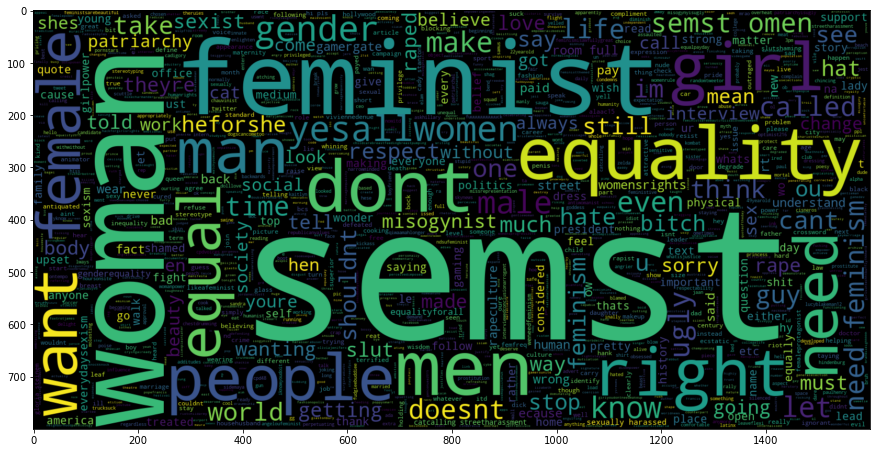

In [84]:
#FAVOR STANCE WORDCLOUD


plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_feminist[data_feminist[3] == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

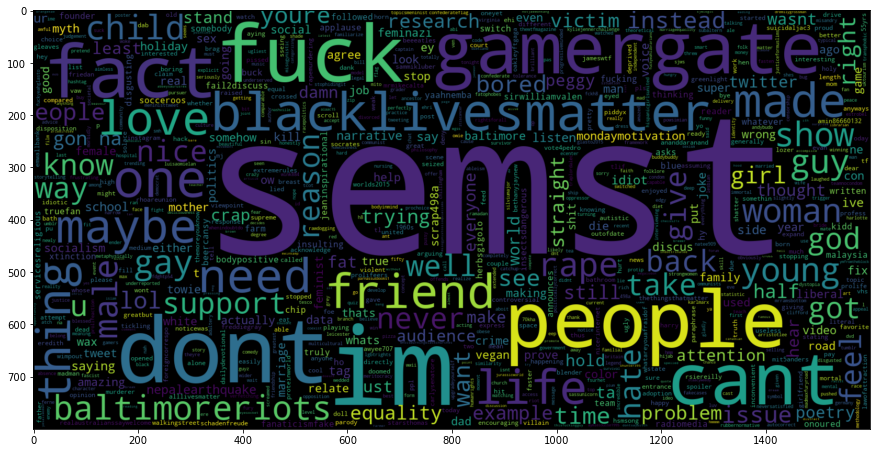

In [85]:
#NEITHER STANCE WORDCLOUD

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_feminist[data_feminist[3] == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

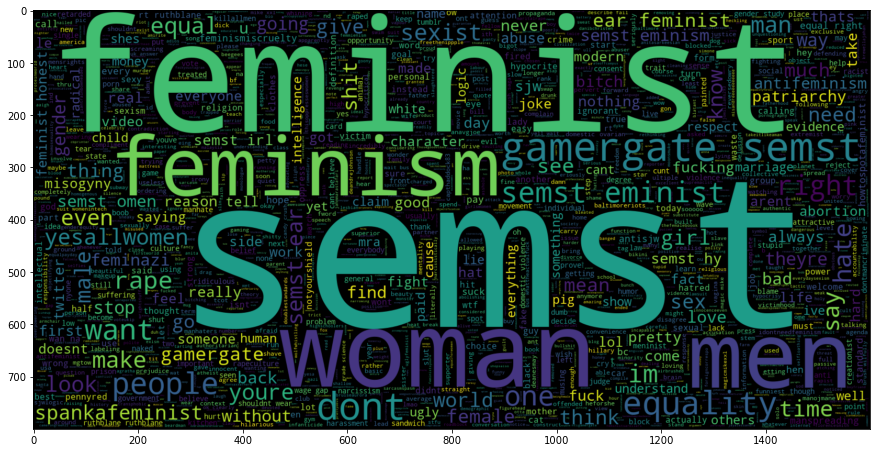

In [86]:
#AGAINST STANCE WORDLOUD

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_feminist[data_feminist[3] == -1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')